# Import

In [1]:
import glob
import bed_lib as bl
import os
import div_trans_lib as dt
import pandas as pd
from multiprocessing import Pool

%matplotlib inline

In [2]:
# To not have to restart the kernel everytime I change the module lib1_bed
%load_ext autoreload
%autoreload 2

**WARNINGS**

USING NAME SORTED BAMS !!

- TOFIX bedpe option apparently filter out the pairs with insert < 0
- TRY filtering only uniquely mapping reads (MAPQ 255) and compare with filtering only primary

# Analysis

## Input

In [316]:
bams = glob.glob('/home/ekornobis/hub/divtrans/data/bams/*nameSort.bam')
# For testing
bams = glob.glob('/home/ekornobis/hub/divtrans/data/bams/test/*nameSort.bam')
bams

['/home/ekornobis/hub/divtrans/data/bams/test/mini_veude_nameSort.bam',
 '/home/ekornobis/hub/divtrans/data/bams/test/mini_A_nameSort.bam']

## Functions

In [321]:
def close_div_filt(row):
    """ Keep only divergent transcription (no convergent)
    """
    # 2 cases for divergent transcription (hence removing convergente transcription)
    if row.iloc[1] <= row.iloc[7] and row.iloc[5] == '-':
        return True
    elif row.iloc[1] >= row.iloc[7] and row.iloc[5] == '+':
        return True
    else:
        return False

def get_div_read_intervals(row):
        return [row.iloc[0], min(row.iloc[[1,2,7,8]]), max(row.iloc[[1,2,7,8]]), '.', '.', '.']

def process_bam(bam):
    """ Filter the bam and produce a bed of fragments"""
    # Remove read unmapped, mate unmapped, only primary, no spliced
    filt_bam = dt.bam_filtering(bam)
    # Generate fragments from read pairs and orient them properly
    bedpe = dt.bam_to_fragments(filt_bam)
    bedfrag = dt.bedpe_to_fragbed(bedpe)
    bedfrag = bl.Bed(bedfrag)
    return bedfrag

def get_div_reads(bed):
    """ Get couples of closest reads on opposite strands"""
    df = bed.to_dataframe(index_col=None)
    
    # Separate + and - strands
    pos_strand_df = df[df[5] == '+']
    neg_strand_df = df[df[5] == '-']
    
    pos_bed = bl.df_to_bed(pos_strand_df, bed.path + "_plus.bed")
    neg_bed = bl.df_to_bed(neg_strand_df, bed.path + "_minus.bed")
    
    # The divergent read should always be looked upstream considering
    # the orientation of bedA (see bedtools closest manual)
    bed1 = pos_bed.closest(neg_bed, supp_args='-D a -id')
    bed2 = neg_bed.closest(pos_bed, supp_args='-D a -id')
    closest_bed = bed1.concat(bed2).move_to(bed.path + "_closest_concat.bed")
    
    # Ignore overlaping reads to look for reads further away
    # Treat special cases where overlapping hide divergent transcription (test with test/frag.bed)
    # This will overwrite the previous beds so need to be concat sequentially
    bed3 = pos_bed.closest(neg_bed, supp_args='-D a -id -io')
    closest_bed = closest_bed.concat(bed3).move_to(bed.path + "_closest_concat.bed")
    
    bed4 = neg_bed.closest(pos_bed, supp_args='-D a -id -io')
    closest_bed = closest_bed.concat(bed4).move_to(bed.path + "_closest_concat.bed")
    
    df = closest_bed.to_dataframe(index_col=None)
    
    # Filtering convergence (still detected when reads are overlapping)
    df = df.loc[df.apply(close_div_filt, axis=1)]
    df = df[(abs(df[12]) <= 500)]
    
    return df

def process_fragbed(fragbed):
    """ Process fragments beds to extract divergent transcription intervals"""
    # -c 6 -o distinct is to keep the strand info
    bedmerge = fragbed.sort().merge(supp_args='-s -c 4,5,6 -o min,distinct,distinct') 
    
    df = get_div_reads(bedmerge)
    
    # remove GL contigs
    df = df[[not str(x).startswith('GL') for x in df.iloc[:,0]]]
    
    # For cases where no close reads can be found, bedtools add -1 as coordinates
    # This filters this case out
    sel = (df.iloc[:,1] != -1) & (df.iloc[:,2] != -1) & (df.iloc[:,7] != -1) & (df.iloc[:,8] != -1)
    df = df.loc[sel,:]

    out_prefix = os.path.splitext(bedmerge.path)[0]

    df = pd.DataFrame(list(df.apply(get_div_read_intervals, axis=1)))
    
    div_read_intervals = bl.df_to_bed(df, out_prefix + '_div_read.bed')
    
    # Clustering instead of merging was necessary to get the interval between divergent reads
    #cluster_div_reads = div_read_intervals.sort().cluster()
    #get_div_trans_intervals(cluster_div_reads.path, out_prefix + 'div_trans_final.bed')
    
    final_bed = div_read_intervals.sort().merge()
    
    return final_bed

## Processing

Generate beds for divergence transcription detection

In [323]:
p = Pool(2)
fragbeds = p.map(process_bam, bams)
final_beds = p.map(process_fragbed, fragbeds)

/home/ekornobis/programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
/home/ekornobis/programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
Process ForkPoolWorker-327:
Process ForkPoolWorker-328:
Traceback (most recent call last):
  File "/home/ekornobis/programs/anaconda3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ekornobis/programs/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ekornobis/programs/anaconda3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ekornobis/programs/anaconda3/lib/python3.5/multiprocessing/pool.py", line 108, in wo

**OR** from already generated 'frag_clean' bed files

In [324]:
fragbeds = [bl.Bed(x) for x in glob.glob('/home/ekornobis/hub/divtrans/data/bams/*frag_clean.bed')]
# For testing
#fragbeds = [bl.Bed(x) for x in glob.glob('/home/ekornobis/hub/divtrans/data/test/frag.bed')]
fragbeds

[<Bed object: VEUDE_A_1_nameSort_filt_frag_clean>,
 <Bed object: Compoud_A_1_nameSort_filt_frag_clean>]

In [326]:
p = Pool(2)
final_beds = p.map(process_fragbed, fragbeds)

/home/ekornobis/programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
/home/ekornobis/programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
/home/ekornobis/programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
/home/ekornobis/programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:64: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.


Extract feature in A but not in vehicule (**VERIFY THE ORDER IN final_beds IF NEW EXECUTION**)

In [166]:
final_beds

[<Bed object: VEUDE_A_1_nameSort_filt_frag_cleandiv_trans_final.bed>,
 <Bed object: Compoud_A_1_nameSort_filt_frag_cleandiv_trans_final.bed>]

Subtracting vehicule from Compound A and removing refseq intervals

In [48]:
ref_genes='/home/ekornobis/data/genomes/ensembl/h_sapiens/hg37/hg19_refseq_sort.bed'

# Renaming is necessary beacuse zsh complains about too long file names
A_bed = final_beds[0].move_to('../results/A_divtrans.bed')
vehi_bed = final_beds[1].move_to('../results/vehicule_divtrans.bed')

A_bed.subtract(vehi_bed, supp_args='-A').subtract(bl.Bed(ref_genes), supp_args='-A').rename('../results/A-minus-vehicule_divtrans_noRefSeq.bed')

<Bed object: A-minus-vehicule_divtrans_noRefSeq.bed>

## Stats

,Nbases,Nintervals,bedobj,name,path
0,11100321,49752,<Bed object: A_divtrans.bed>,A_divtrans.bed,../results/A_divtrans.bed
1,11289522,50342,<Bed object: vehicule_divtrans.bed>,vehicule_divtrans.bed,../results/vehicule_divtrans.bed


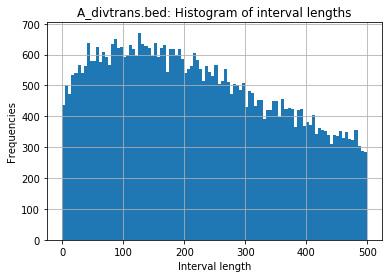

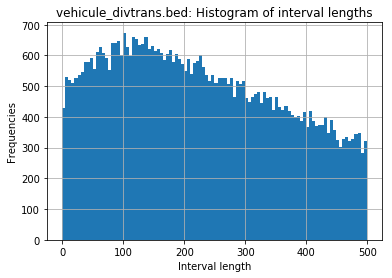

In [49]:
stats_df = []
for bed in final_beds:
    stats_df.append(bed.stats())
    bed.plot()
    
stats_df = pd.DataFrame(stats_df)
stats_df

 # Legacy (previous analysis version)

## v1

In [269]:
#### LEGACY
def OLD_get_div_read_intervals(row):
    """Get the end of the upstream read and the start of the downstream read
     """
    
    if row.iloc[5] == '-':
        interval = {'chr': row.iloc[0], 'start': row.iloc[2], 'end': row.iloc[7], 'name': row.iloc[3] + row.iloc[9],  'score': '.', 'strand': '.'}
    elif row.iloc[5] == '+':
        interval = {'chr': row.iloc[0], 'start': row.iloc[8], 'end': row.iloc[1], 'name': row.iloc[3] + row.iloc[9],  'score': '.', 'strand': '.'}
    else:
        raise IOError('Something is wrong')
    return interval


def close_div_filt(row):
    """ Keep only divergent transcription (no convergent)
    and remove 'GL' contigs"""
    
    if str(row.iloc[0]).startswith('GL'):
        return False    
    # 2 cases for divergent transcription (hence removing convergente transcription)
    elif row.iloc[1] < row.iloc[7] and row.iloc[5] == '-':
        return True
    elif row.iloc[1] > row.iloc[7] and row.iloc[5] == '+':
        return True
    else:
        return False
    
# This was usefull when getting the intervals between reads 
# A merge might be sufficient if not needing the internal interval
def get_div_trans_intervals(bed, bed_out):
    cluster_dict = {}
    with open(bed) as f:
        for line in f:
            line = line.split()
            cluster_dict[line[6]] = cluster_dict.get(line[6], list()) + [(line[0], line[1], line[2])]
            
    with open(bed_out, 'w') as f: 
        for k, v in cluster_dict.items():
            chro = v[0][0]
            start = min([interval[1] for interval in v])
            end = max([interval[2] for interval in v])
        
            f.write('{0}\t{1}\t{2}\n'.format(chro, start, end))

## v0

In [9]:
%%bash

bams=`ls /home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/*_nameSort.bam`

for bam in $bams; do
    echo "Processing: $bam"
    bed=${bam%.bam}_bothMapped_primaryAlign_noSplice_frag.bed
    # Remove read unmapped, mate unmapped, only primary, no spliced
    # The bams are sorted by names for proper bedtools bamtobed bedpe
    samtools view -h -F 0x4 -F 0x8 -F 0x100 $bam | \
    awk '{if ($1 ~ /^@/) {print} else if ($6 !~ /N/) {print}}' | \
    samtools view -bh > ${bam%.bam}_filtered.bam
    bedtools bamtobed -bedpe -mate1 -i ${bam%.bam}_filtered.bam > $bed 2> bedpe.log
    echo "DONE: $bam"
    echo "BED OUT: $bed"
    echo "Widow reads:" $(wc -l bedpe.log | cut -f1,1 -d' ')
    
    python /home/ekornobis/code/muchardt/seqherv/2.1_bedpe_to_fragBed.py $bed > ${bed%.bed}_clean.bed
    
    awk '($3-$2 < 500) {print}' ${bed%.bed}_clean.bed | \
    sort -k1,1 -k2,2n | \
    bedtools merge -s -i - | \
    awk -v OFS='\t' '{print $1, $2, $3, ".", ".", $4}' > ${bed%.bed}_inf500_merged.bed
    
    # Separate strands and get shortest distance between different expressed strands
    out_bed1=${bed%.bed}_div_dist1.bed
    out_bed2=${bed%.bed}_div_dist2.bed
    
    grep "-" ${bed%.bed}_inf500_merged.bed | bedtools sort -i - > ${bed%.bed}_strand-.bed
    grep "+" ${bed%.bed}_inf500_merged.bed | bedtools sort -i - > ${bed%.bed}_strand+.bed
     
    bedtools closest -d -a ${bed%.bed}_strand-.bed -b ${bed%.bed}_strand+.bed > $out_bed1
    bedtools closest -d -b ${bed%.bed}_strand-.bed -a ${bed%.bed}_strand+.bed > $out_bed2
    
    # Filter out based on minimal distance between 2 opposite strand expression regions
    awk '($13 <= 100) {print}' $out_bed1 > ${bed%.bed}_all_oppositeStrands_dist100b.bed
    awk '($13 <= 100) {print}' $out_bed2 >> ${bed%.bed}_all_oppositeStrands_dist100b.bed
    
done

Processing: /home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/Compoud_A_1_nameSort.bam
DONE: /home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/Compoud_A_1_nameSort.bam
BED OUT: /home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/Compoud_A_1_nameSort_bothMapped_primaryAlign_noSplice_frag.bed
Widow reads: 12907206
Processing: /home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/VEUDE_A_1_nameSort.bam
DONE: /home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/VEUDE_A_1_nameSort.bam
BED OUT: /home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/VEUDE_A_1_nameSort_bothMapped_primaryAlign_noSplice_frag.bed
Widow reads: 13596423


INFO:__main__:Number of pairs mapping on different chromosomes: 0
INFO:__main__:Min frag_length: 100; Max frag_length: 2450629;
INFO:__main__:Number of pairs mapping on different chromosomes: 0
INFO:__main__:Min frag_length: 100; Max frag_length: 1845804;


In [11]:
%%bash

bams=`ls /home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/*_nameSort.bam`

# Apply other distance between 2 opposite strand expression regions
for bam in $bams; do 

    bed=${bam%.bam}_bothMapped_primaryAlign_noSplice_frag.bed
    out_bed1=${bed%.bed}_div_dist1.bed
    out_bed2=${bed%.bed}_div_dist2.bed
       
   awk '($13 <= 500) {print}' $out_bed1 > ${bed%.bed}_all_oppositeStrands_dist500b.bed
   awk '($13 <= 500) {print}' $out_bed2 >> ${bed%.bed}_all_oppositeStrands_dist500b.bed
done

In [12]:
closest_div_bed = glob.glob('/home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/*all_oppositeStrands_dist500b.bed')

In [6]:
closest_div_bed

['/home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/Compoud_A_1_nameSort_bothMapped_primaryAlign_noSplice_frag_all_oppositeStrands_dist500b.bed',
 '/home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/VEUDE_A_1_nameSort_bothMapped_primaryAlign_noSplice_frag_all_oppositeStrands_dist500b.bed']

In [13]:
for bed in closest_div_bed:
    outfile = os.path.splitext(bed)[0] + '_joined.bed'
    with open(outfile, 'w') as f:
        for line in open(bed, 'r'):
            line = line.split()
            coords = [int(line[1]), int(line[2]), int(line[7]), int(line[8])]
            # Skip negative values for positions obtained for 'GL' contigs
            coords = [x for x in coords if x >= 0]
            f.write('{0}\t{1}\t{2}\t{3}\t{4}\t{5}\n'.format(line[0], min(coords), max(coords), '.', '.', '.'))

In [14]:
%%bash

beds=`ls /home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star/*_joined.bed`

for bed in $beds; do
    bedtools sort -i $bed | bedtools merge > ${bed%.bed}_merged.bed
    done

In [15]:
%%bash

cd /home/ekornobis/analysis/muchardt/seqherv/11.1_divtrans_ribominus/star

ref_genes=/home/ekornobis/data/genomes/ensembl/h_sapiens/hg37/hg19_refseq_sort.bed

bedtools subtract -A -a Compoud_A_1_nameSort_bothMapped_primaryAlign_noSplice_frag_all_oppositeStrands_dist500b_joined_merged.bed -b VEUDE_A_1_nameSort_bothMapped_primaryAlign_noSplice_frag_all_oppositeStrands_dist500b_joined_merged.bed > A_minus_veude_divtrans_dist500b.bed

# Remove intervals contained in known genes
bedtools subtract -A -a A_minus_veude_divtrans_dist500b.bed -b $ref_genes > A_minus_veude_final_dist500b_noRefSeq.bed

# Count by strands
awk -v OFS='\t' '{print $0, ".", ".", "+"}' A_minus_veude_final_noRefSeq.bed > A_minus_veude_final_noRefSeq_strand+.bed
awk -v OFS='\t' '{print $0, ".", ".", "-"}' A_minus_veude_final_noRefSeq.bed > A_minus_veude_final_noRefSeq_strand-.bed

#bedtools coverage -a Compoud_A_1_nameSort_filtered.bam -b A_minus_veude_final_noRefSeq_strand+.bed

awk: fatal: cannot open file `A_minus_veude_final_noRefSeq.bed' for reading (No such file or directory)
awk: fatal: cannot open file `A_minus_veude_final_noRefSeq.bed' for reading (No such file or directory)


In [ ]:
# Used for final 500bp interval centered on the middle of divtrans region
# awk -v OFS='\t' '{print $1, int(($2 + $3)/2 - 251), int(($2 + $3)/2 + 250)}' A_minus_veude_final_dist500b_noRefSeq.bed > A_minus_veude_final_dist500b_noRefSeq_500bWin.bed